In [45]:
import csv
import numpy as np
import math
import pandas as pd
from collections import deque
import copy

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.collections import LineCollection
import matplotlib.cm as cm
from matplotlib import animation
import IPython

__requires__= 'networkx==2.5'
import networkx as nx
print("Networkx version: " + nx.__version__)

%matplotlib nbagg

Networkx version: 2.5


# Identifying Communities by Modularity Optimization

Communities in networks can be identified through the minimization of graph modularity.  In the following cells, an algorithm to find communities is implemented for a mock 2-dimensional system.  This is later applied to a 3D chemical system.


The mock 2D system is created as a "ring of rings".  Where pairs of smaller rings are adjusted to sit more adjacent to each other.  This data set is structured this as to create communities of communities in order to properly demonstrated the iterative process of finding "super" communities within a graph.

<IPython.core.display.Javascript object>


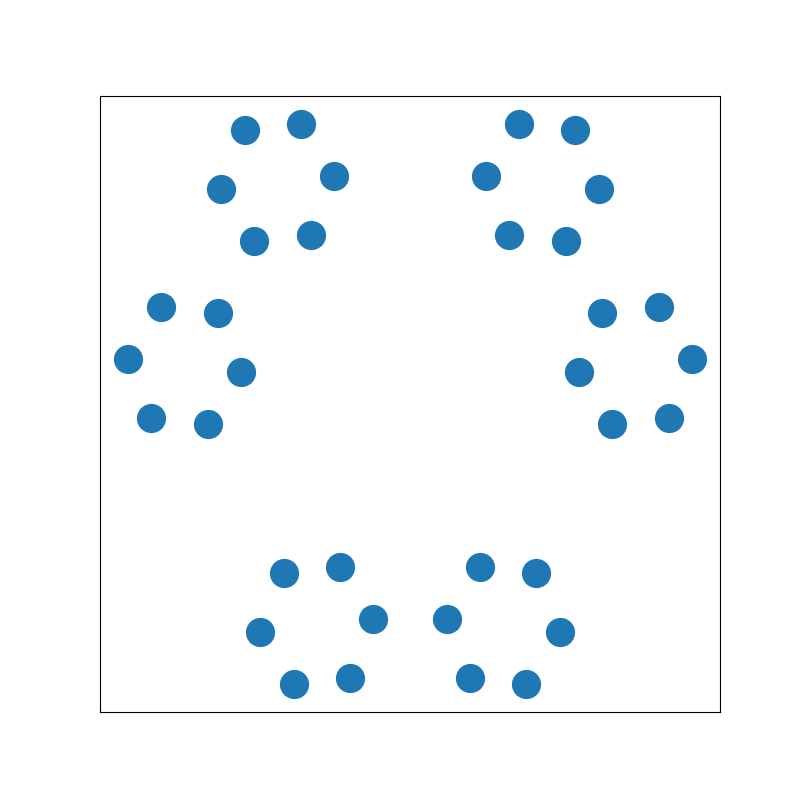

In [46]:
def create_2D_community(): 
    
    r_outer=2
    r_inner=8

    num_phi_outer=6
    num_phi_inner=6
    
    x=deque()
    y=deque()
    x=np.empty(0)
    y=np.empty(0)

    #create alternating sub cluster distances
    lamda=(2*np.pi)/(num_phi_inner) #wavelength
    A=.1 #magnitude

    phi_outer_array=np.arange(0, (2 * np.pi), 2*np.pi/num_phi_outer)

    phi_inner_array=np.arange(0, (2 * np.pi), 2*np.pi/num_phi_inner)
    phi_inner_array+=A*np.cos((phi_inner_array)*np.pi/lamda)

    for phi_outer in phi_outer_array:
        for phi_inner in phi_inner_array:

            x_outer=r_outer*np.cos(phi_outer)+r_inner
            y_outer=r_outer*np.sin(phi_outer)

            r=(x_outer**2+y_outer**2)**(0.5)
            phi=math.atan(y_outer/x_outer)+phi_inner

            x = np.append(x, r*np.cos(phi))
            y = np.append(y, r*np.sin(phi))
    return x,y



x,y = create_2D_community()
# x=x/2
fig_size=8
marker_size=fig_size*50
fig = plt.figure(figsize=(fig_size,fig_size))
plt.tick_params(axis='both', bottom=False, left=False, labelbottom=False, labelleft=False)
ax.set_axis_off()
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)

plt.scatter(x,y, s=marker_size)

# Graph of the 2D System

This function takes the xy data from the 2D system and a user defined distance criteria to create weighted graph.  The graph node attributes are the cartesian coordinates, node color, and a community ID initially set to the node number.  

The graph edges are created for node pairs within the distance criteria and are weighted as the inverse of the euclidean distance.  

In [47]:
def create_primary_graph(x,y,distance_criteria=2**(1/2)): 

    graph=nx.Graph()
    
    for i in range(len(x)):
        graph.add_node(i,
                   x_coord = float(x[i]),
                   y_coord = float(y[i]),
                   z_coord = 0,
                   color = 'white',
                   community_ID = i,
                  )


    #add graph edges based on distances
    #weight edges based on inverse distance
    for i in range(len(x)):
        for j in range(len(x)):
            if (i<j):
                xi=graph.nodes[i]['x_coord']
                xj=graph.nodes[j]['x_coord']
                yi=graph.nodes[i]['y_coord']
                yj=graph.nodes[j]['y_coord']
                distance=np.sqrt((xi-xj)**2+(yi-yj)**2)
                
                if ( distance <= distance_criteria):
                    graph.add_edge(i,j,weight = 1/distance)
   
    return graph
                            
G=create_primary_graph(x,y,distance_criteria=1)

# Plotting

This function colors the nodes in the graph to a user defined color map as a function of community ID.  The minimum and maximum ID's are used to normalize the spread of the cluster ID numbers across the maximum color gradient length.

A set of line segment are also added to visualize the edges in the graph.

Initially, each node has a unique community ID, and so the first graph shows node associations.

In [48]:
def plot_graph(graph: "networkx.classes.graph.Graph", color_map):
    
    text = []

    plt.figure(figsize=(fig_size,fig_size))
    ax = plt.axes()
    ax.set_axis_off()

    #Map graph node colors to color map
    min=len(graph.nodes())
    max=0
    for node in graph.nodes():
        if graph.nodes[node]['community_ID']<min:
            min=graph.nodes[node]['community_ID']
        if graph.nodes[node]['community_ID']>max:
            max=graph.nodes[node]['community_ID']
    gradientDistance=max-min
    for node in graph.nodes():
        graph.nodes[node]['color']=eval("cm." + color_map + "((graph.nodes[node]['community_ID']-min)/gradientDistance)")




    #plot graph nodes
    for i in range(len(graph.nodes())):
        ax.scatter(
            graph.nodes[i]['x_coord'],
            graph.nodes[i]['y_coord'],
            color= graph.nodes[i]['color'],
            edgecolors='black',
            s=marker_size,
            zorder=3
        )

        #annotate nodes with community ID number            
        text.append( ax.text(
            graph.nodes[i]['x_coord'],
            graph.nodes[i]['y_coord'],
            graph.nodes[i]['community_ID'],
            ha='center', va='center'
        ))

    #plot graph edges as line segments
    segments=deque()
    for i in range(len(graph.edges())):
        u=list(graph.edges)[i][0]
        v=list(graph.edges)[i][1]
        segment=[(
            graph.nodes[u]['x_coord'],
            graph.nodes[u]['y_coord']),(
            graph.nodes[v]['x_coord'],
            graph.nodes[v]['y_coord']
        )]
        segments.append(segment)

    lc = LineCollection(segments, colors='dimgray',linestyle='--')
    ax.add_collection(lc)

<IPython.core.display.Javascript object>


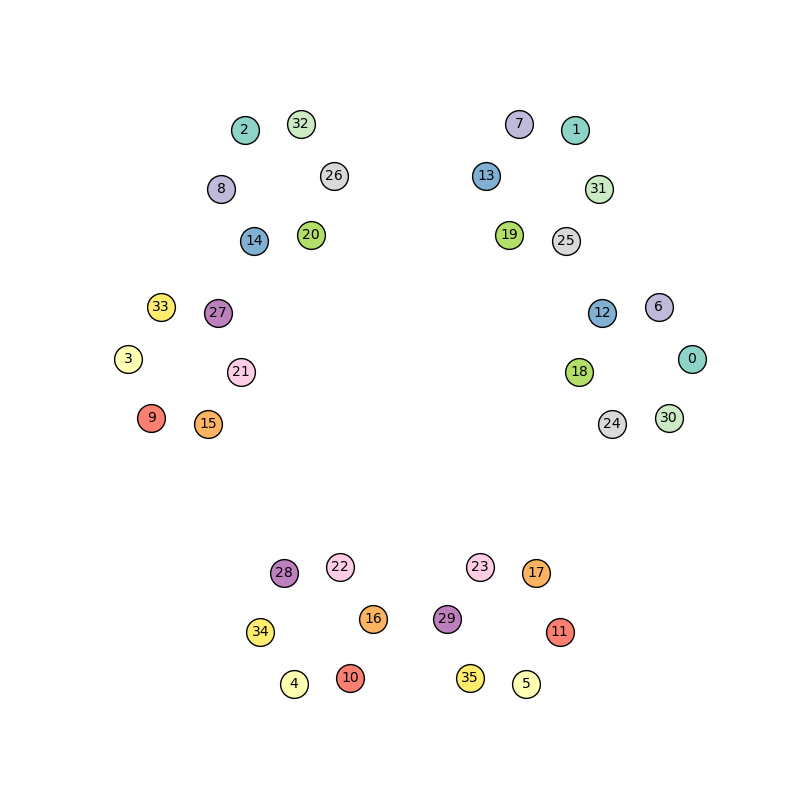

In [49]:
plot_graph(G,'Set3')

# Community Partition

The community partition value to be maximized is given by the product of the graph modularity and a delta function. The graph modularity $X$ is given by the following equation.

$X=\frac{1}{2m}\sum_{ij}{[A_{ij}-\frac{k_ik_j}{2m}]}$ where

$A_{ij}$ is the weight of the edge between $i$ and $j$

$k_i=\sum_jA_{ij}$ is the sum of weights of edges to $i$

$m=\frac{1}{2}\sum_{ij}A_{ij}$

The community partition function Q is then 

$Q=X\delta(c_i,c_j)$ where

$\delta$ is the delta function of $c_i,c_j$ where

$c_i$ is the community of $i$

The following function calculates the community partion for a given graph.

In [42]:
#calculate  Q
def calcQ(graph: "networkx.classes.graph.Graph"):
    X=pd.DataFrame(nx.modularity_matrix(graph))
    Q=0
    for index_i, node_i in enumerate(graph.nodes()):
        for index_j, node_j in enumerate(graph.nodes()):
            if (graph.nodes[node_i]['community_ID']==graph.nodes[node_j]['community_ID']):
                delta_c=1
            if (graph.nodes[node_i]['community_ID']!=graph.nodes[node_j]['community_ID']):
                delta_c=0
            X[index_i][index_j]*=delta_c
            Q+=X[index_i][index_j]
    
    Q/=2*len(graph.edges())
    return Q

# Maximize Q

In first phase of the community partition maximization, nodes are moved to new communitites and the a new partition function is calculated.  If the new Q is greater than the previous value the move to the new community is accepted.  This is performed iteratively over all nodes until the value of Q no longer changes.

In this function, an initial plot of the graph is made, and upon successful movement of a node to a new community, the graph node color and community ID are updated to reflect the change.  At the end of this process the first level of communities are defined, but the larger communities of communities have still not been successfully grouped together.

<IPython.core.display.Javascript object>


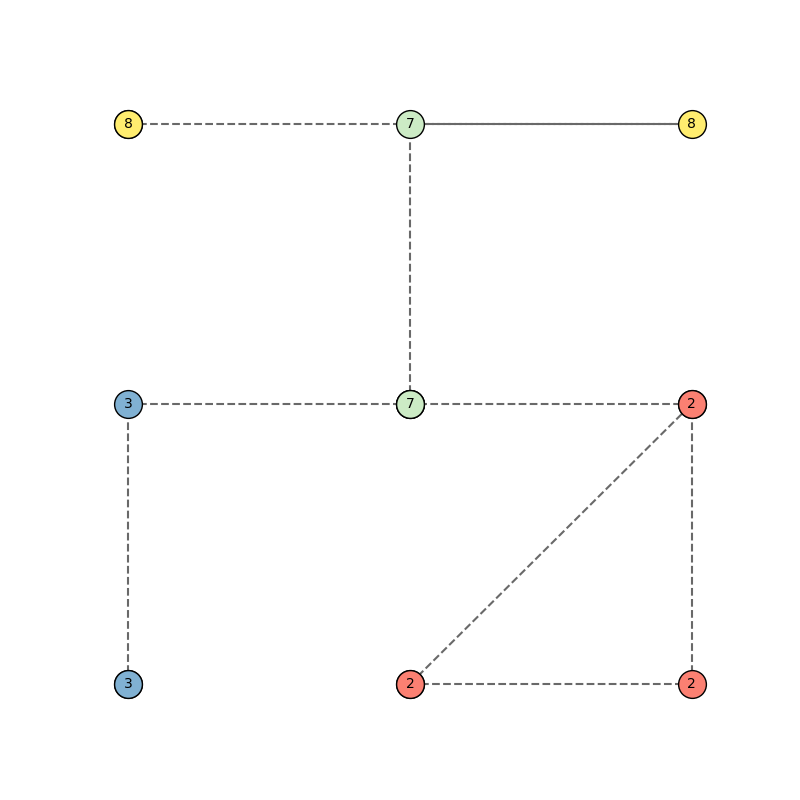

In [43]:
def phase1(graph):
    
#     graph_copy = graph
    graph_copy = copy.deepcopy(graph)
    
    fig_size=8
    marker_size=fig_size*50
    fig = plt.figure(figsize=(fig_size,fig_size))
    ax = plt.axes()
    ax.set_axis_off()
    text = []
    
    for i in range(len(graph_copy.nodes())):
        ax.scatter(
            graph_copy.nodes[i]['x_coord'],
            graph_copy.nodes[i]['y_coord'],
            color= graph_copy.nodes[i]['color'],
            edgecolors='black',
            s=marker_size,
            zorder = 3
        )
        text.append( ax.text(
            graph_copy.nodes[i]['x_coord'],
            graph_copy.nodes[i]['y_coord'],
            graph_copy.nodes[i]['community_ID'],
            ha='center', va='center'
        ))

    segments=deque()
    for i in range(len(graph_copy.edges())):
        u=list(graph_copy.edges)[i][0]
        v=list(graph_copy.edges)[i][1]
        segment=[(
            graph_copy.nodes[u]['x_coord'],
            graph_copy.nodes[u]['y_coord']),(
            graph_copy.nodes[v]['x_coord'],
            graph_copy.nodes[v]['y_coord']
        )]
        segments.append(segment)

    lc = LineCollection(segments, colors='dimgray',linestyle='--')
    ax.add_collection(lc)


    
    
    
    convergedQ='NA'
    Q=calcQ(graph_copy)

    while convergedQ != Q:
        convergedQ=Q
        for i in range(len(graph_copy.nodes())):
            for j in nx.neighbors(graph_copy,i):
                origCommunityID=graph_copy.nodes[i]['community_ID']
                C=graph_copy.nodes[j]['community_ID']  #new Community
                if graph_copy.nodes[i]['community_ID']!=C:
                    graph_copy.nodes[i]['community_ID']=C
                    graph_copy.nodes[i]['community_ID']=graph_copy.nodes[j]['community_ID']
                    newQ=calcQ(graph_copy)
                    if (newQ<=Q):
                        graph_copy.nodes[i]['community_ID']=origCommunityID
                    if (newQ>Q):

                        Q=newQ
#                         print(Q)
                        #recolor and relabel node
                        graph_copy.nodes[i]['color']=graph_copy.nodes[j]['color']
                        ax.scatter(
                            graph_copy.nodes[i]['x_coord'],
                            graph_copy.nodes[i]['y_coord'],
                            color= graph_copy.nodes[i]['color'],
                            edgecolors='black',
                            s=marker_size,
                            zorder = 3
                        )
                        text[i].set_text(graph_copy.nodes[i]['community_ID'])
                        fig.canvas.draw()
    return(graph_copy)
                        
H= phase1(G)

<IPython.core.display.Javascript object>


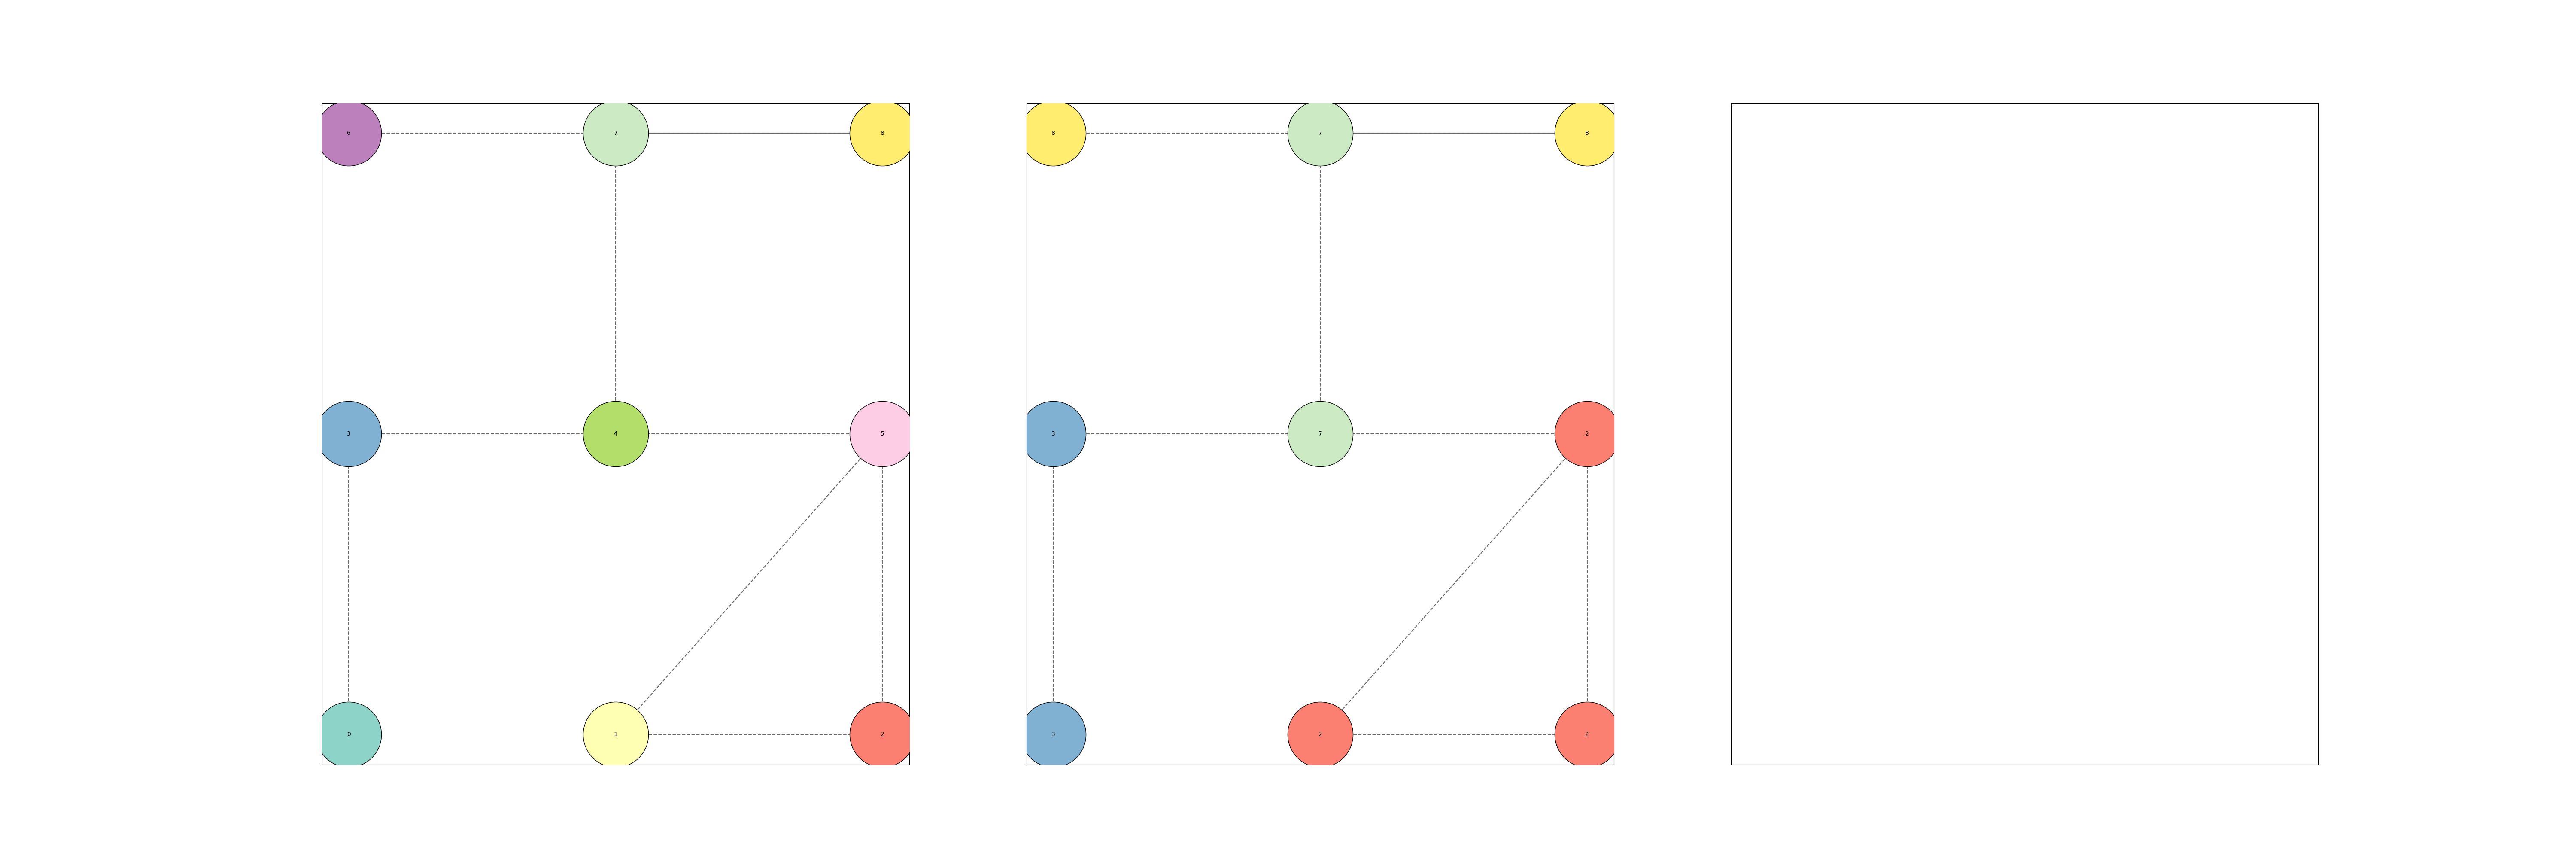

NameError: name 'final_graph' is not defined

In [44]:
fig_size=8
marker_size=fig_size*50*30

# fig = plt.figure(figsize=(fig_size,fig_size))

fig, axes = plt.subplots(1,3)
fig.set_figheight(20)
fig.set_figwidth(60)
# axes[0].scatter(x,y)
# axes[1].scatter(x,y)
# axes[2].scatter(x,y)
# plot_graph(G,'Set3')
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    
text = []

#plot G nodes
for i in range(len(G.nodes())):
    axes[0].scatter(
        G.nodes[i]['x_coord'],
        G.nodes[i]['y_coord'],
        color= G.nodes[i]['color'],
        edgecolors='black',
        s=marker_size,
        zorder=3
    )

    #annotate nodes with community ID number            
    text.append( axes[0].text(
        G.nodes[i]['x_coord'],
        G.nodes[i]['y_coord'],
        G.nodes[i]['community_ID'],
        ha='center', va='center'
    ))

#plot G edges as line segments
segments=deque()
for i in range(len(G.edges())):
    u=list(G.edges)[i][0]
    v=list(G.edges)[i][1]
    segment=[(
        G.nodes[u]['x_coord'],
        G.nodes[u]['y_coord']),(
        G.nodes[v]['x_coord'],
        G.nodes[v]['y_coord']
    )]
    segments.append(segment)

lc = LineCollection(segments, colors='dimgray',linestyle='--')
axes[0].add_collection(lc)


#plot H nodes
for i in range(len(H.nodes())):
    axes[1].scatter(
        H.nodes[i]['x_coord'],
        H.nodes[i]['y_coord'],
        color= H.nodes[i]['color'],
        edgecolors='black',
        s=marker_size,
        zorder=3
    )

    #annotate nodes with community ID number            
    text.append( axes[1].text(
        H.nodes[i]['x_coord'],
        H.nodes[i]['y_coord'],
        H.nodes[i]['community_ID'],
        ha='center', va='center'
    ))

#plot H edges as line segments
segments=deque()
for i in range(len(H.edges())):
    u=list(H.edges)[i][0]
    v=list(H.edges)[i][1]
    segment=[(
        H.nodes[u]['x_coord'],
        H.nodes[u]['y_coord']),(
        H.nodes[v]['x_coord'],
        H.nodes[v]['y_coord']
    )]
    segments.append(segment)

lc = LineCollection(segments, colors='dimgray',linestyle='--')
axes[1].add_collection(lc)

#plot final_graph nodes
for i in range(len(final_graph.nodes())):
    axes[2].scatter(
        final_graph.nodes[i]['x_coord'],
        final_graph.nodes[i]['y_coord'],
        color= final_graph.nodes[i]['color'],
        edgecolors='black',
        s=marker_size,
        zorder=3
    )

    #annotate nodes with community ID number            
    text.append( axes[2].text(
        final_graph.nodes[i]['x_coord'],
        final_graph.nodes[i]['y_coord'],
        final_graph.nodes[i]['community_ID'],
        ha='center', va='center'
    ))

#plot final_graph edges as line segments
segments=deque()
for i in range(len(final_graph.edges())):
    u=list(final_graph.edges)[i][0]
    v=list(final_graph.edges)[i][1]
    segment=[(
        final_graph.nodes[u]['x_coord'],
        final_graph.nodes[u]['y_coord']),(
        final_graph.nodes[v]['x_coord'],
        final_graph.nodes[v]['y_coord']
    )]
    segments.append(segment)

lc = LineCollection(segments, colors='dimgray',linestyle='--')
axes[2].add_collection(lc)

fig.tight_layout(pad=0.5)

filePathLoad="C:/Users/dpope/OneDrive - Washington State University (email.wsu.edu)/Documents/Projects/Book/test.eps"

plt.savefig(filePathLoad, format='eps', dpi=1600)
plt.rc('font', size=50, weight='bold')          # controls default text sizes